# CF density visualization

Loading model on cpu...
 idx=10
Query: [ 1.15677752 -0.38989579], Class: 1 -> Target: 0


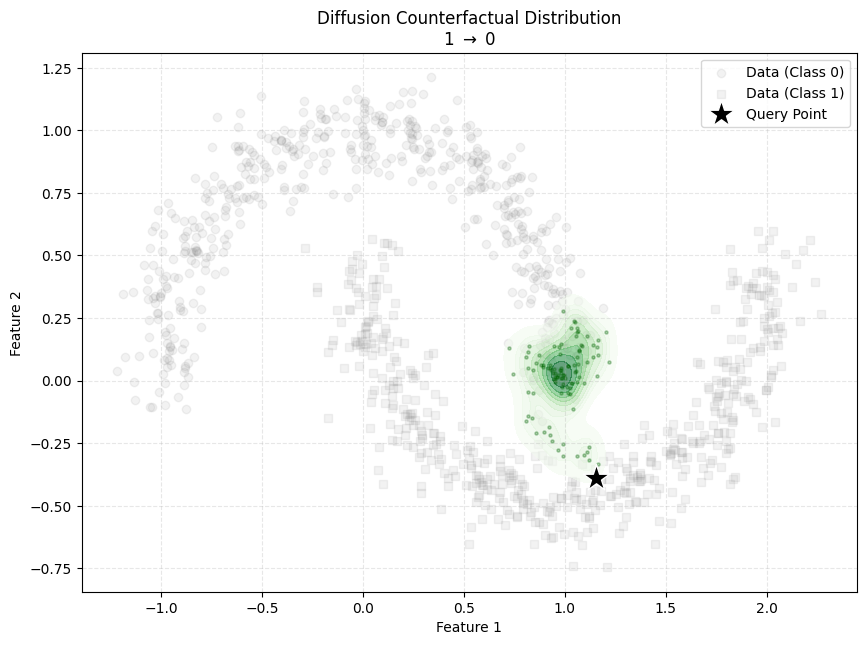

 idx=20
Query: [-0.04027286  0.15633953], Class: 1 -> Target: 0


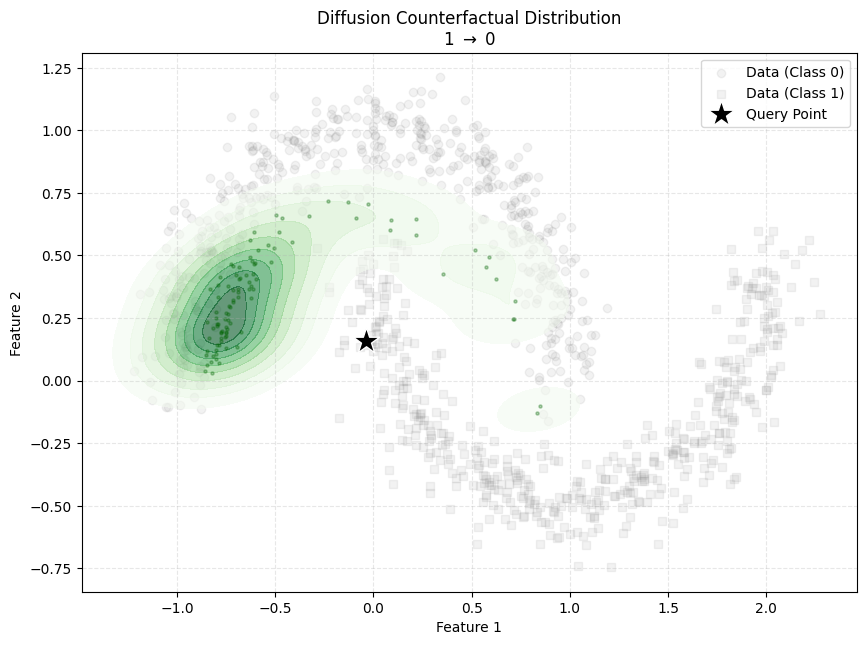

 idx=30
Query: [-0.43226109  0.92191368], Class: 0 -> Target: 1


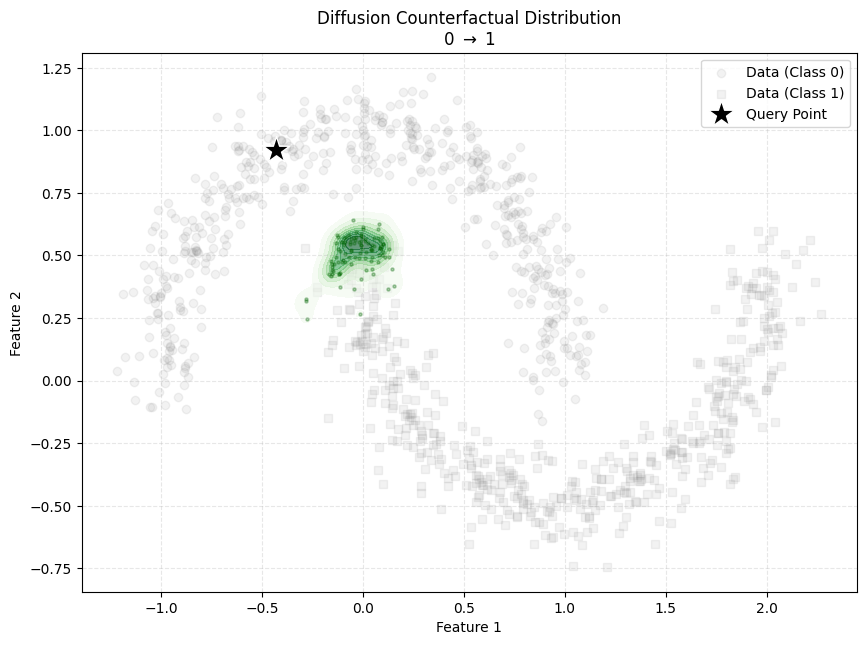

 idx=40
Query: [-0.60848831  1.0690225 ], Class: 0 -> Target: 1


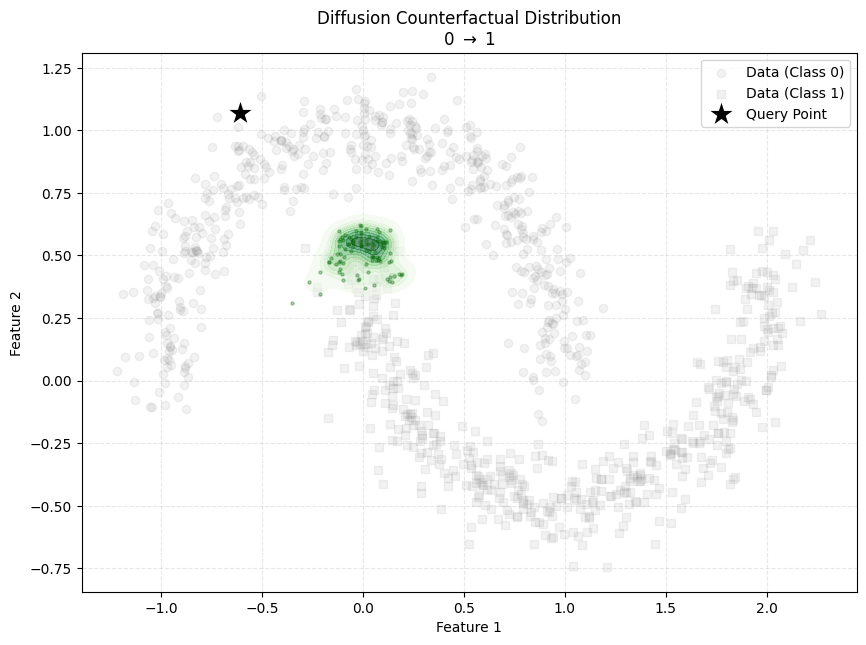

 idx=50
Query: [-0.01699332  0.05851968], Class: 1 -> Target: 0


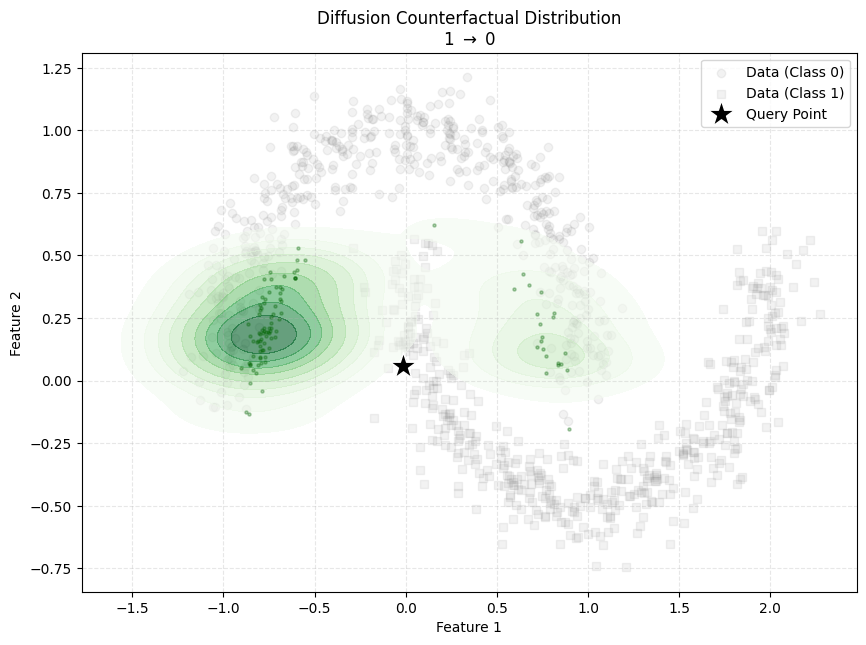

 idx=60
Query: [-0.0315971   0.84674239], Class: 0 -> Target: 1


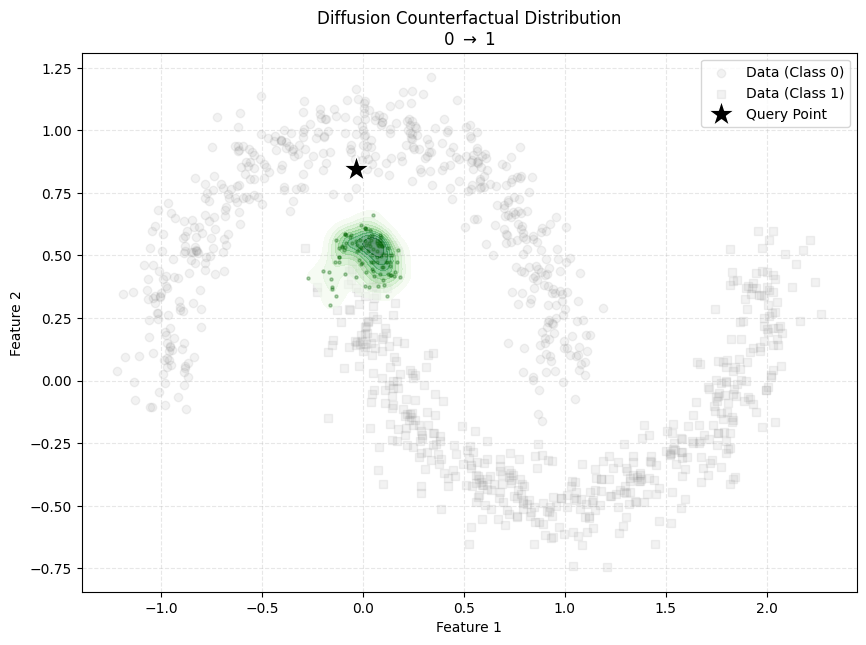

 idx=70
Query: [0.71110401 0.55100981], Class: 0 -> Target: 1


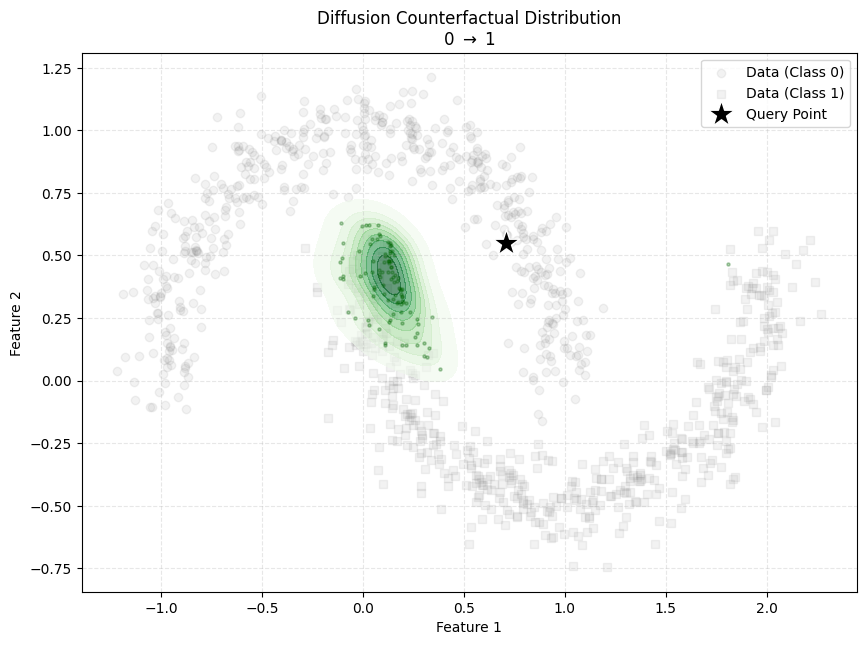

 idx=80
Query: [ 0.70215501 -0.57841483], Class: 1 -> Target: 0


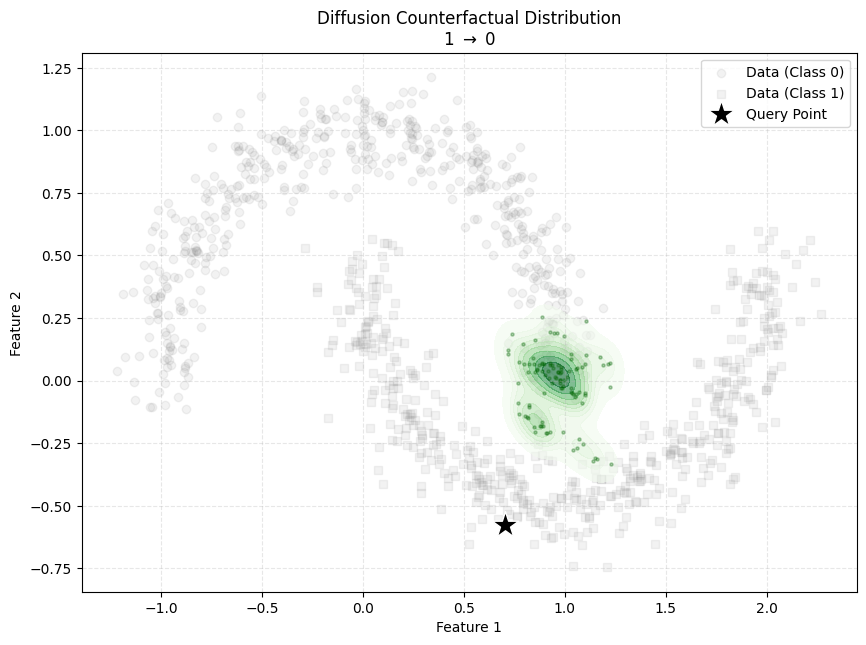

 idx=90
Query: [-0.5401955   0.74353675], Class: 0 -> Target: 1


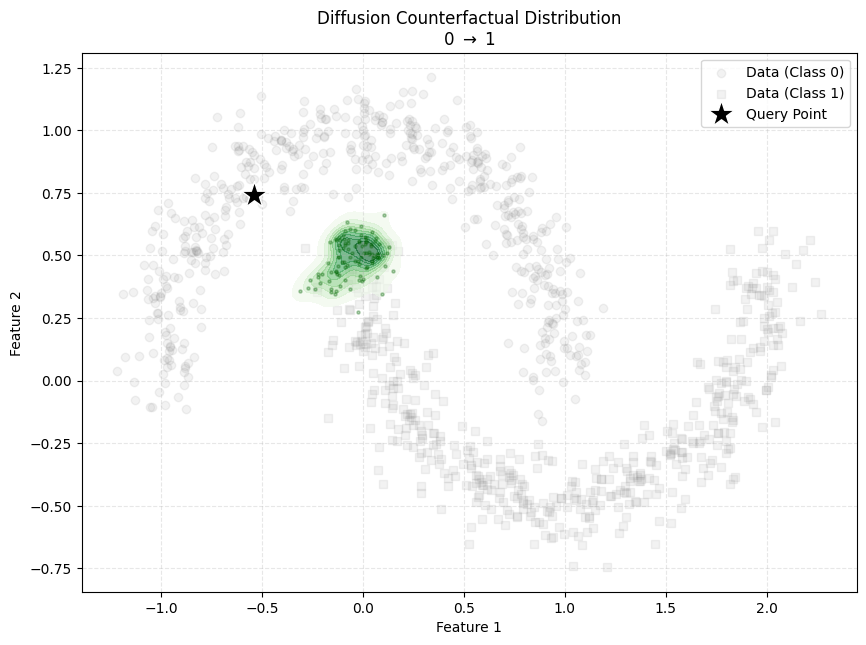

 idx=100
Query: [ 0.84804832 -0.65319849], Class: 1 -> Target: 0


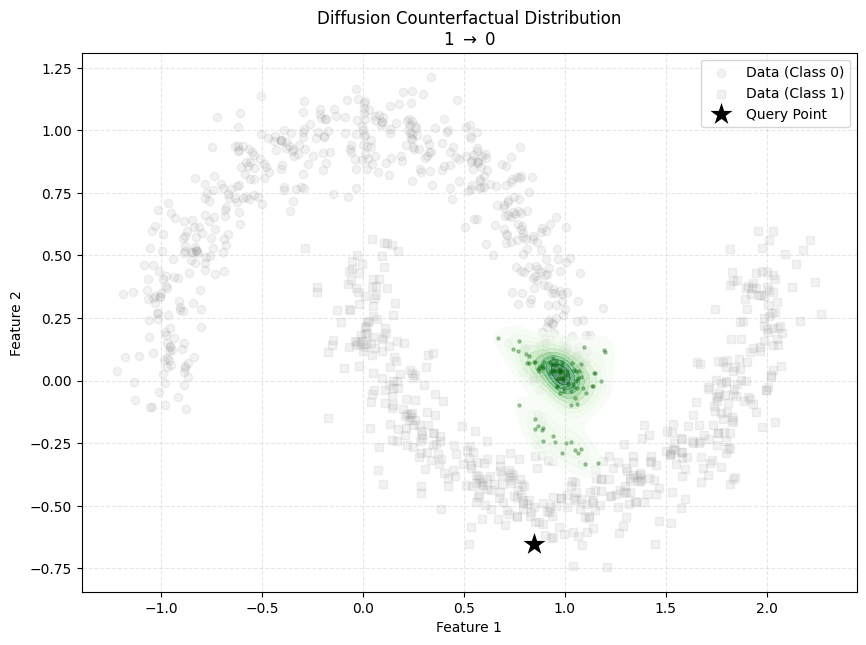

 idx=110
Query: [0.0654712  0.37788934], Class: 1 -> Target: 0


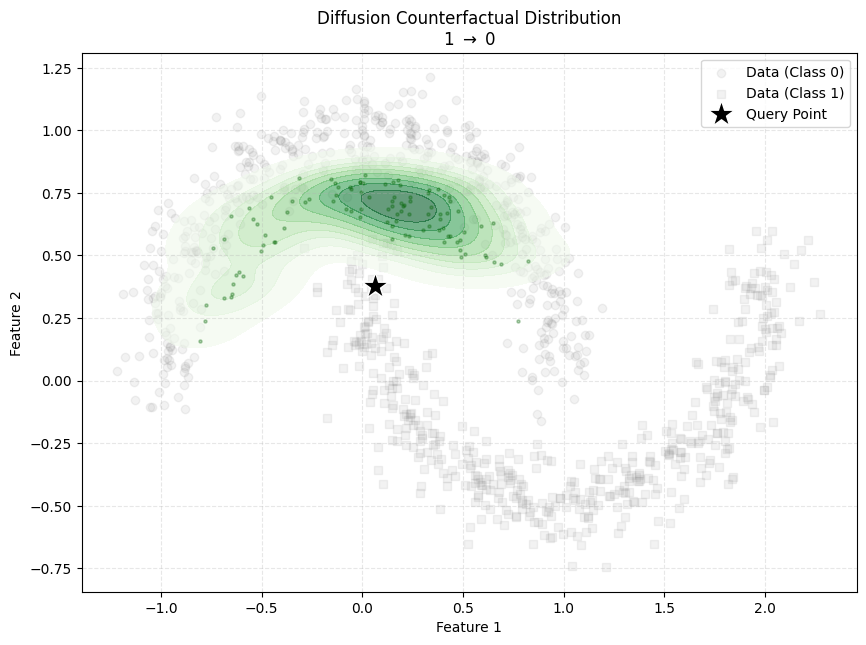

 idx=120
Query: [ 1.82621499 -0.14516856], Class: 1 -> Target: 0


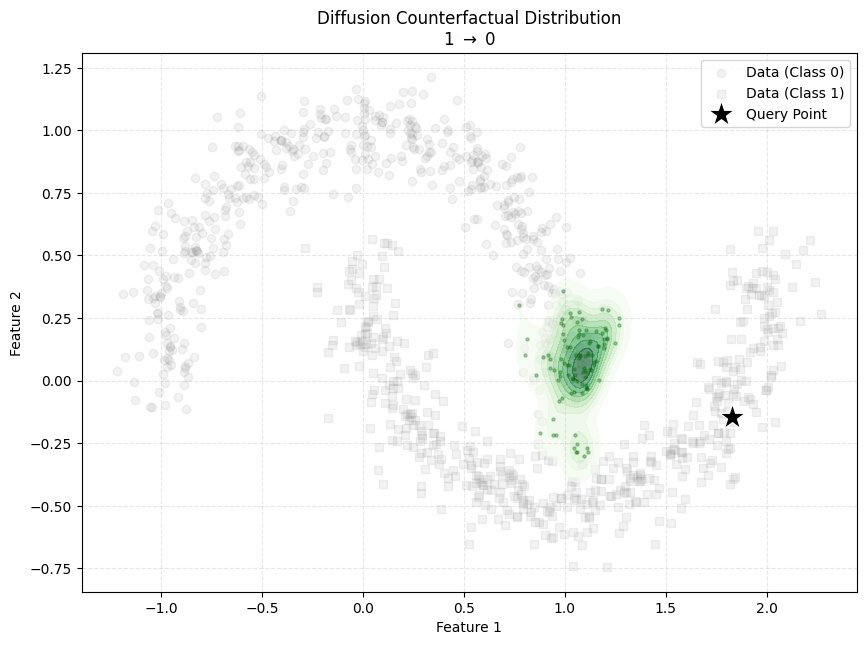

 idx=130
Query: [ 0.25937279 -0.07900138], Class: 1 -> Target: 0


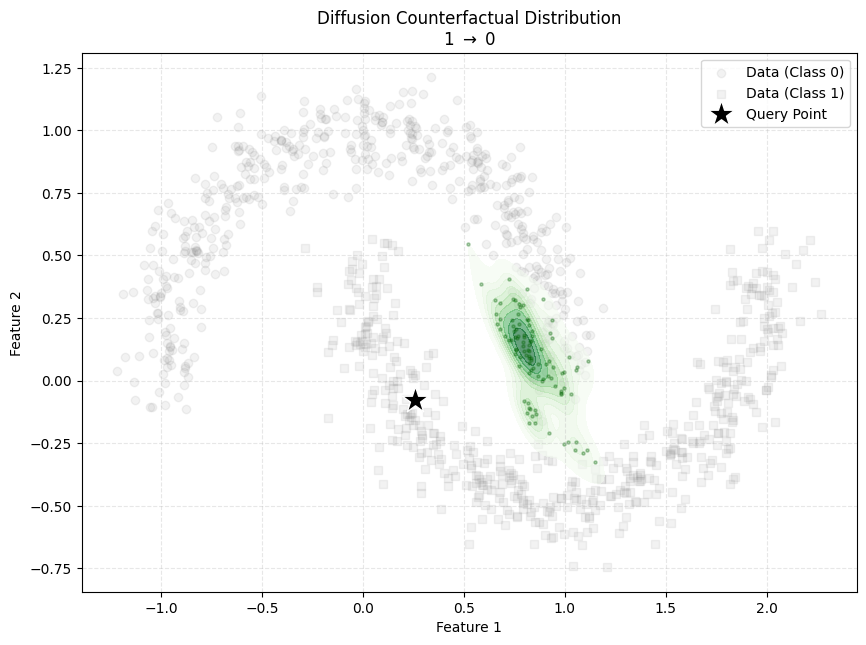

 idx=140
Query: [0.945304  0.1909264], Class: 0 -> Target: 1


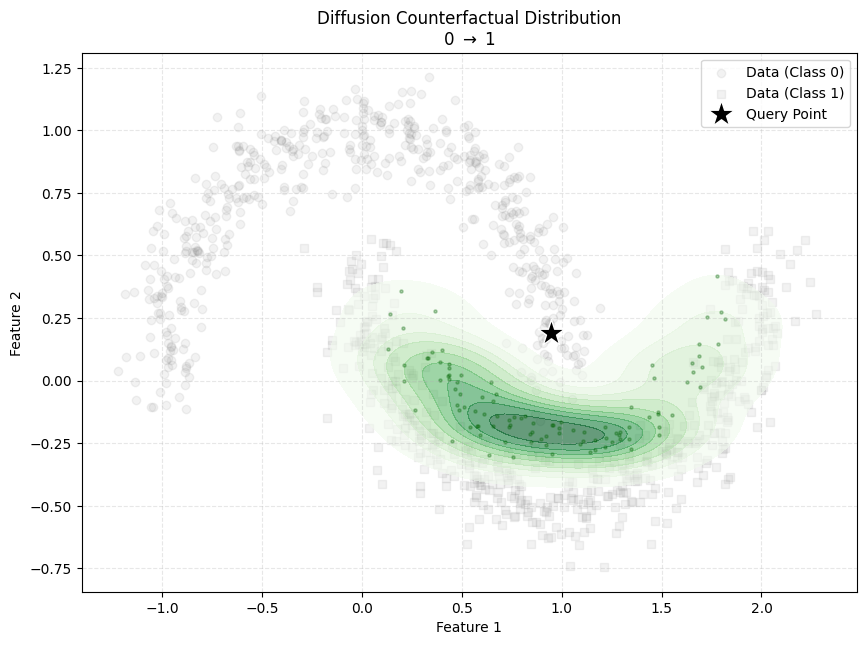

 idx=150
Query: [ 0.30810092 -0.35387293], Class: 1 -> Target: 0


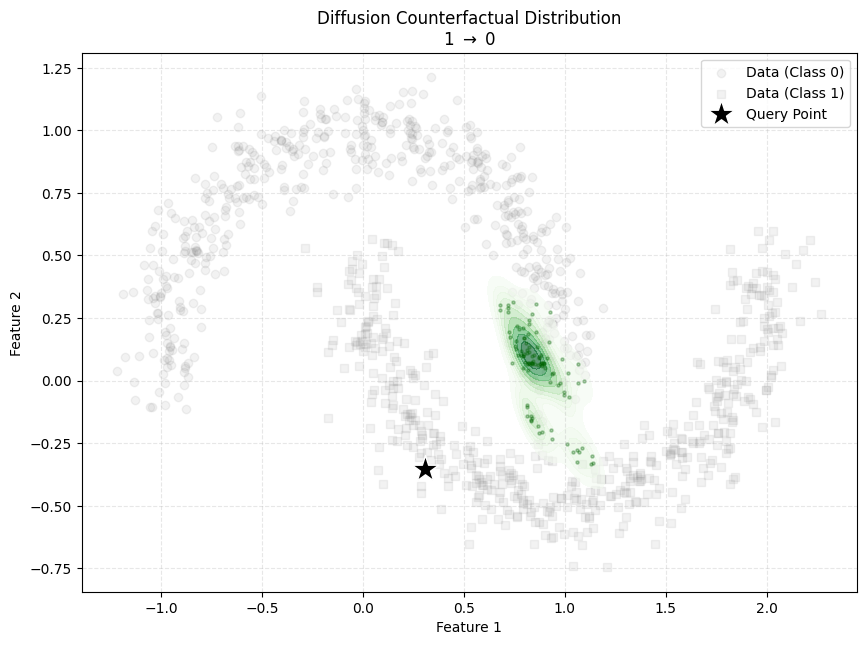

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from types import SimpleNamespace
from tabdce.model.denoise_fn import TabularEpsModel
from tabdce.model.diffusion import MixedTabularDiffusion

def visualize_counterfactual_distribution(
    diffusion_model,
    qt,
    x_bg: np.ndarray,
    y_bg: np.ndarray,
    query_idx: int,
    target_cls: int,
    device: str,
    n_cfs: int = 100,
    save_path: str = None
):
    x_orig_raw = x_bg[query_idx].reshape(1, -1)
    y_orig = y_bg[query_idx]
    
    print(f" idx={query_idx}")
    print(f"Query: {x_orig_raw.flatten()}, Class: {y_orig} -> Target: {target_cls}")
    if qt:
        x_orig_model = qt.transform(x_orig_raw).astype(np.float32)
    else:
        x_orig_model = x_orig_raw.astype(np.float32)

    x_orig_tensor = torch.from_numpy(x_orig_model).to(device)
    y_target_tensor = torch.tensor([target_cls], device=device).long()
    x_orig_batch = x_orig_tensor.repeat(n_cfs, 1)
    y_target_batch = y_target_tensor.repeat(n_cfs)

    with torch.no_grad():
        cf_model_tensor = diffusion_model.sample_counterfactual(x_orig_batch, y_target_batch)
    cf_model_np = cf_model_tensor.cpu().numpy()
    if qt:
        cf_model_np = np.clip(cf_model_np, -5.0, 5.0)
        cf_final = qt.inverse_transform(cf_model_np)
    else:
        cf_final = cf_model_np

    plt.figure(figsize=(10, 7))
    plt.scatter(x_bg[y_bg==0, 0], x_bg[y_bg==0, 1], c='gray', marker='o', alpha=0.1, label='Data (Class 0)')
    plt.scatter(x_bg[y_bg==1, 0], x_bg[y_bg==1, 1], c='gray', marker='s', alpha=0.1, label='Data (Class 1)')
    try:
        sns.kdeplot(
            x=cf_final[:, 0], 
            y=cf_final[:, 1], 
            fill=True, 
            cmap="Greens", 
            alpha=0.6, 
            levels=10,
            thresh=0.05,
            label='CF Density'
        )
        plt.scatter(cf_final[:, 0], cf_final[:, 1], c='darkgreen', s=5, alpha=0.3)
    except Exception as e:
        print(f"Nie udało się wygenerować KDE (może za mało punktów?): {e}")
        plt.scatter(cf_final[:, 0], cf_final[:, 1], c='green', alpha=0.5, label='CF Samples')

    # C) PUNKT QUERY
    plt.scatter(
        x_orig_raw[:, 0], x_orig_raw[:, 1], 
        c='black', marker='*', s=400, edgecolors='white', zorder=10, 
        label='Query Point'
    )

    plt.title(f"Diffusion Counterfactual Distribution\n{y_orig} $\\rightarrow$ {target_cls}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

CHECKPOINT_PATH = "../checkpoints/twomoons_diffusion_model.pt" 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model on {DEVICE}...")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)

cfg = checkpoint['config']
qt = checkpoint['dataset_qt']
ohe = checkpoint['dataset_ohe']

num_numerical = qt.n_features_in_ if qt else 0
cat_dims = [len(c) for c in ohe.categories_] if ohe else []
xdim = num_numerical + sum(cat_dims)
denoise_model = TabularEpsModel(
    xdim=xdim,
    cat_dims=cat_dims,
    y_classes=2,
    hidden=getattr(cfg.model, 'hidden_dim', 256)
).to(DEVICE)

diffusion = MixedTabularDiffusion(
    denoise_fn=denoise_model,
    num_numerical=num_numerical,
    num_classes=cat_dims,
    T=cfg.diffusion.T,
    device=DEVICE
).to(DEVICE)

diffusion.load_state_dict(checkpoint['model_state_dict'])
diffusion.eval()

X_bg, y_bg = make_moons(n_samples=1000, noise=0.1, random_state=42)
queries_idx = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150] 

for idx in queries_idx:
    
    current_cls = y_bg[idx]
    target_cls = 1 - current_cls 
    visualize_counterfactual_distribution(
        diffusion_model=diffusion,
        qt=qt,
        x_bg=X_bg,
        y_bg=y_bg,
        query_idx=idx,
        target_cls=target_cls,
        device=DEVICE,
        n_cfs=100 
    )

## KNN and DPP models comparision

Loading ../checkpoints/twomoons_diffusion_model_dpp.pt...
Loading ../checkpoints/twomoons_diffusion_model_knn.pt...


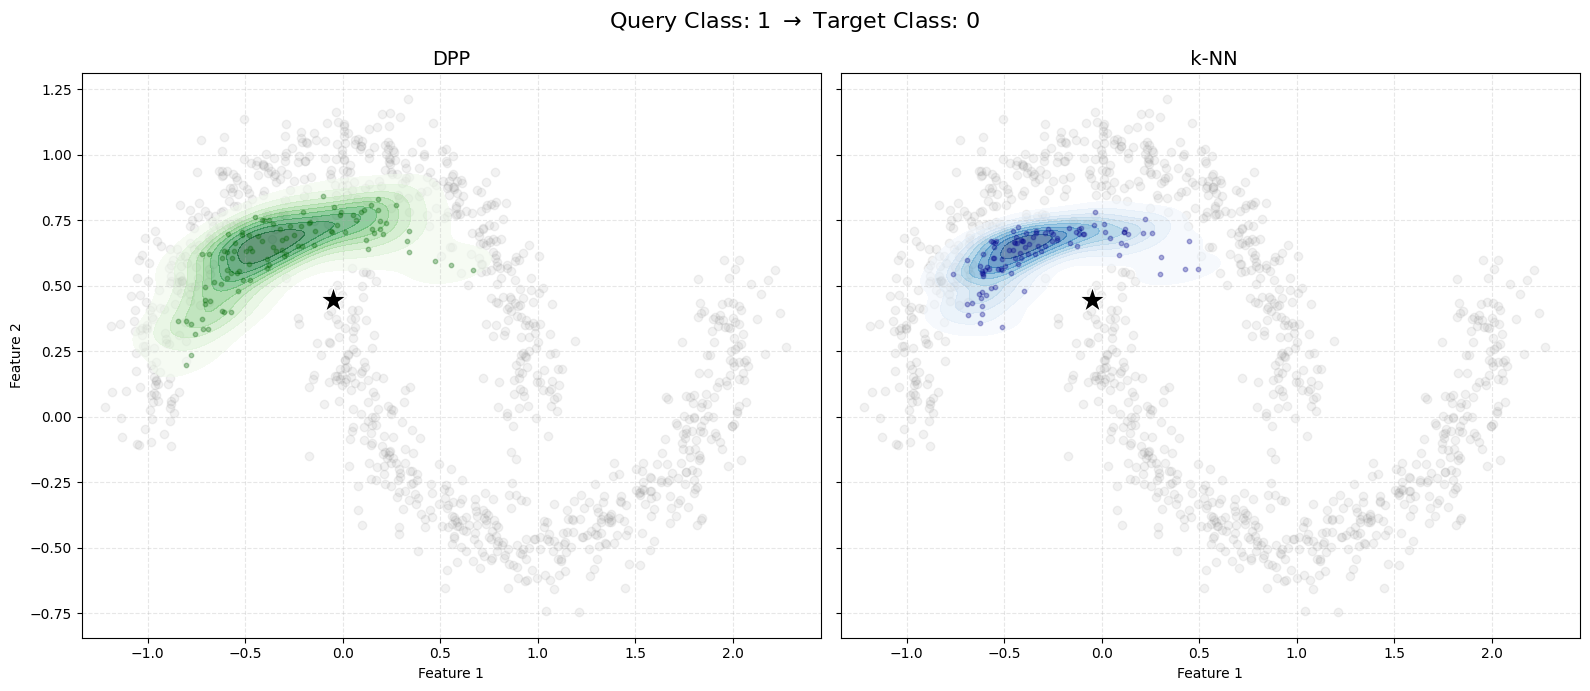

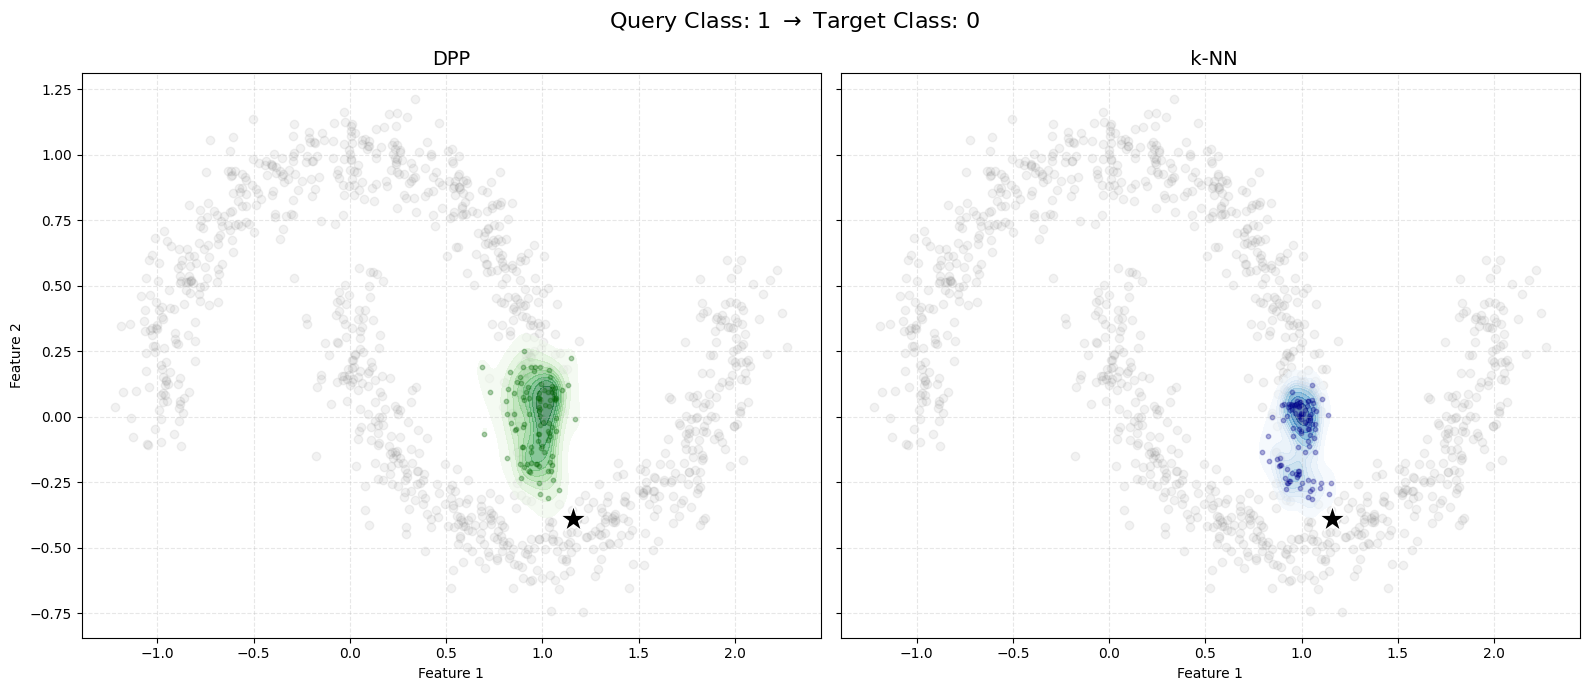

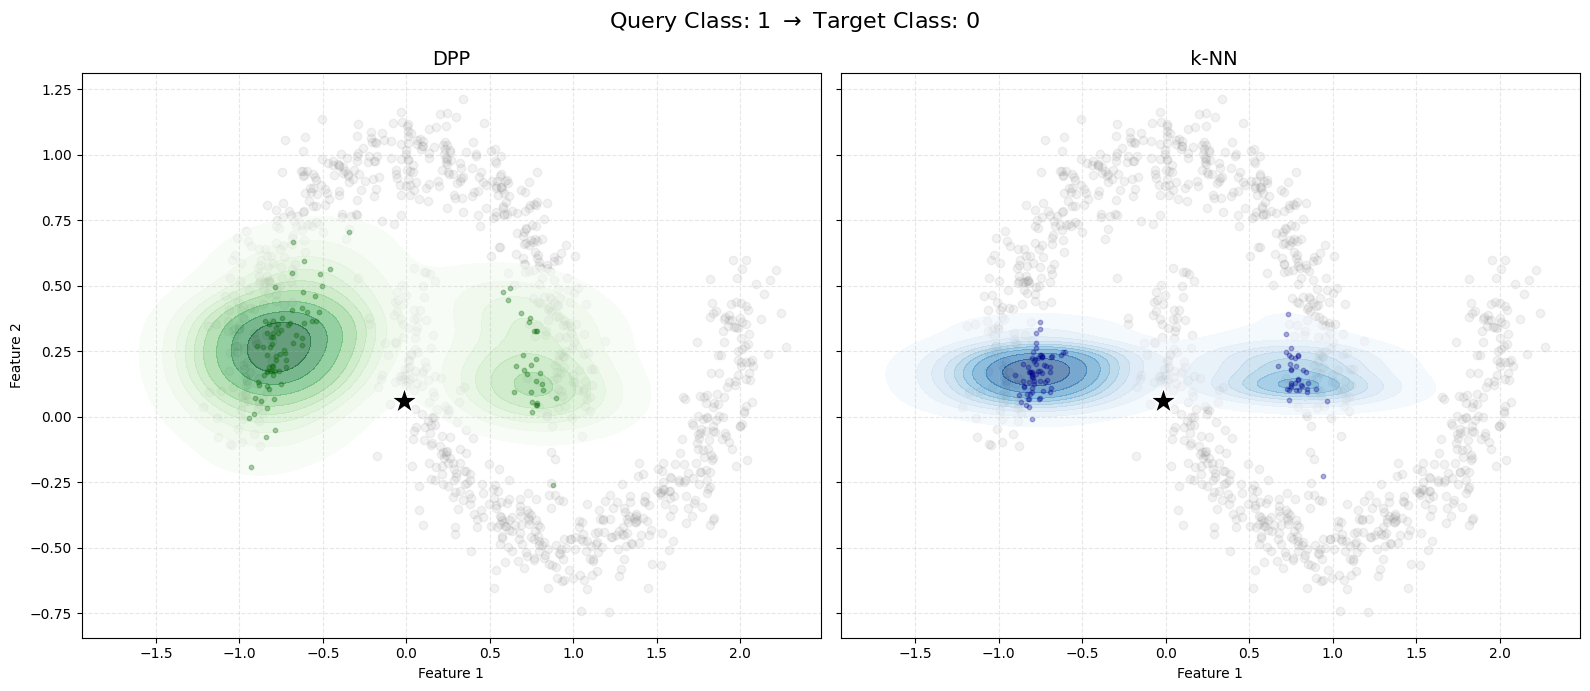

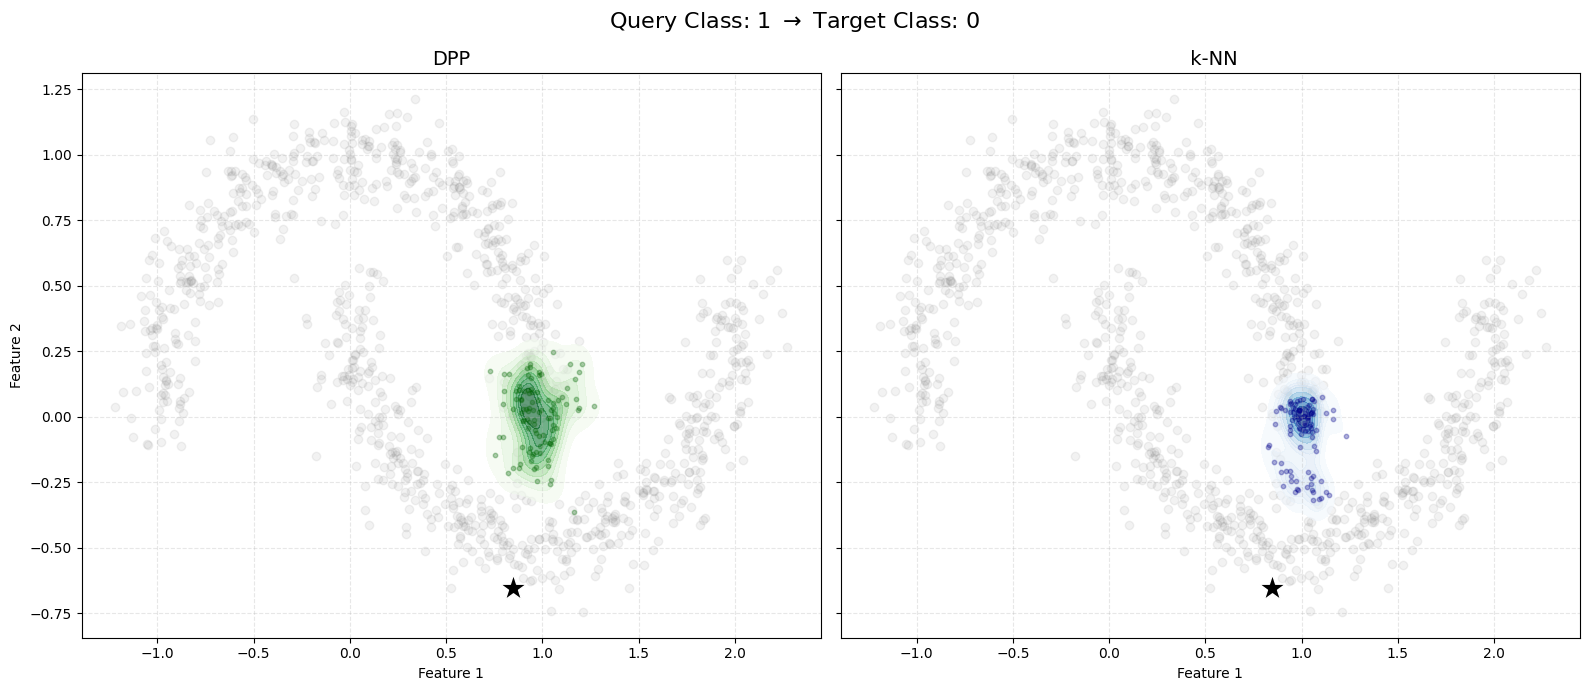

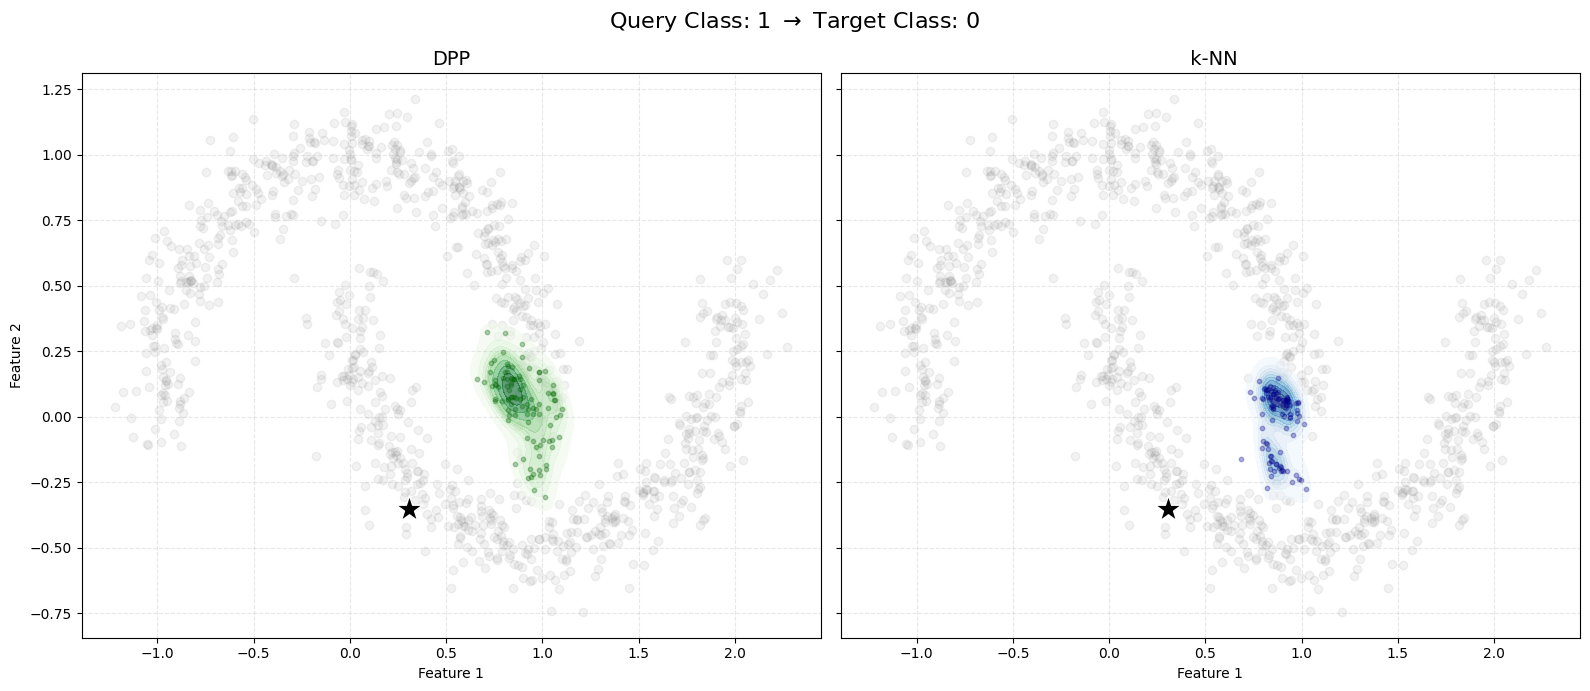

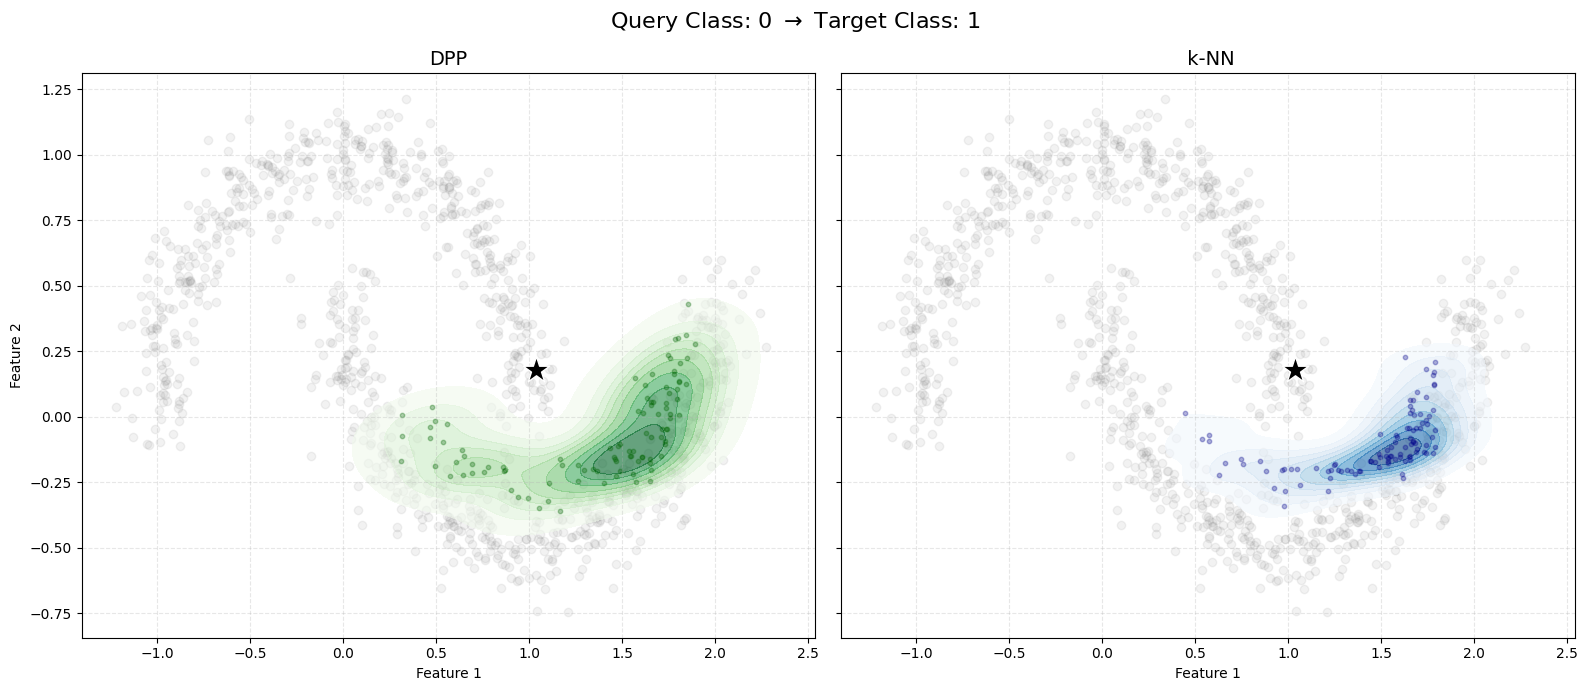

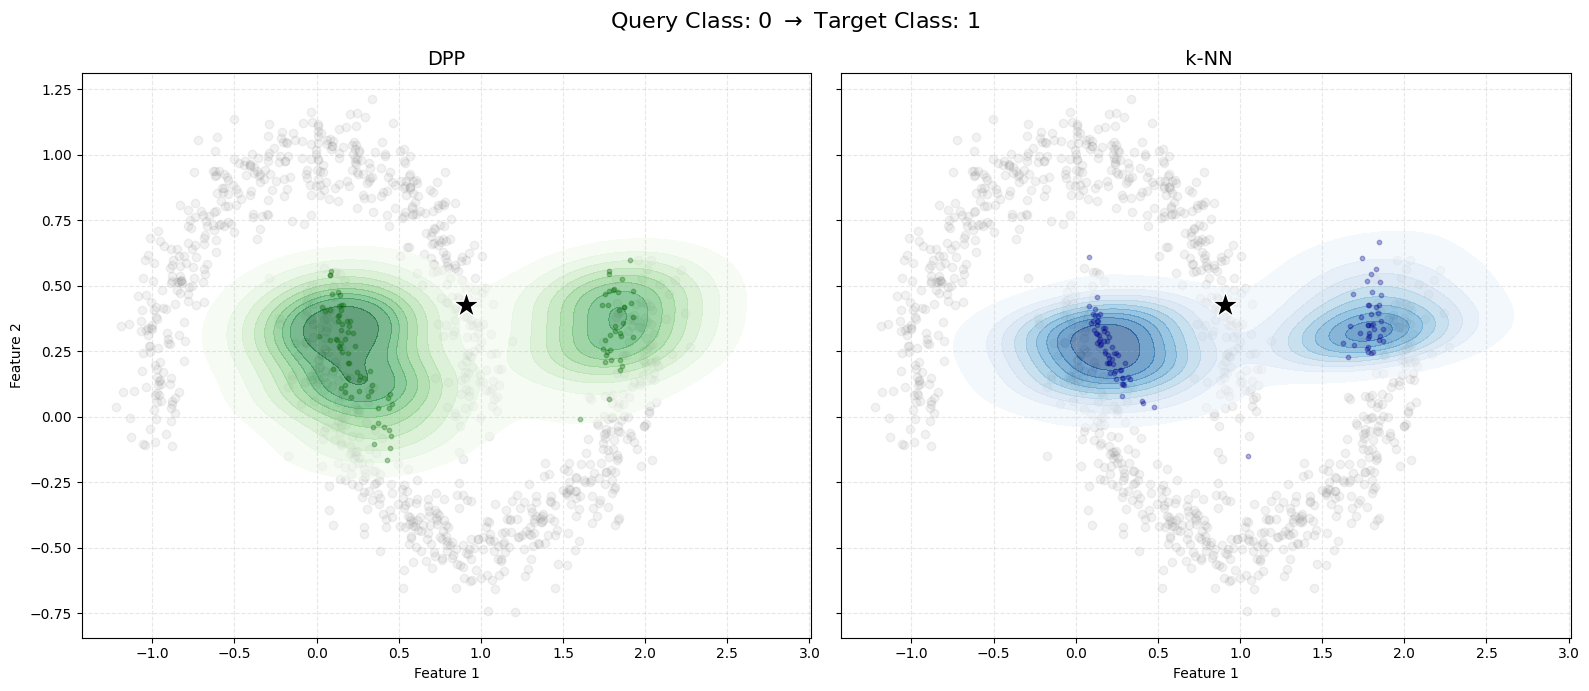

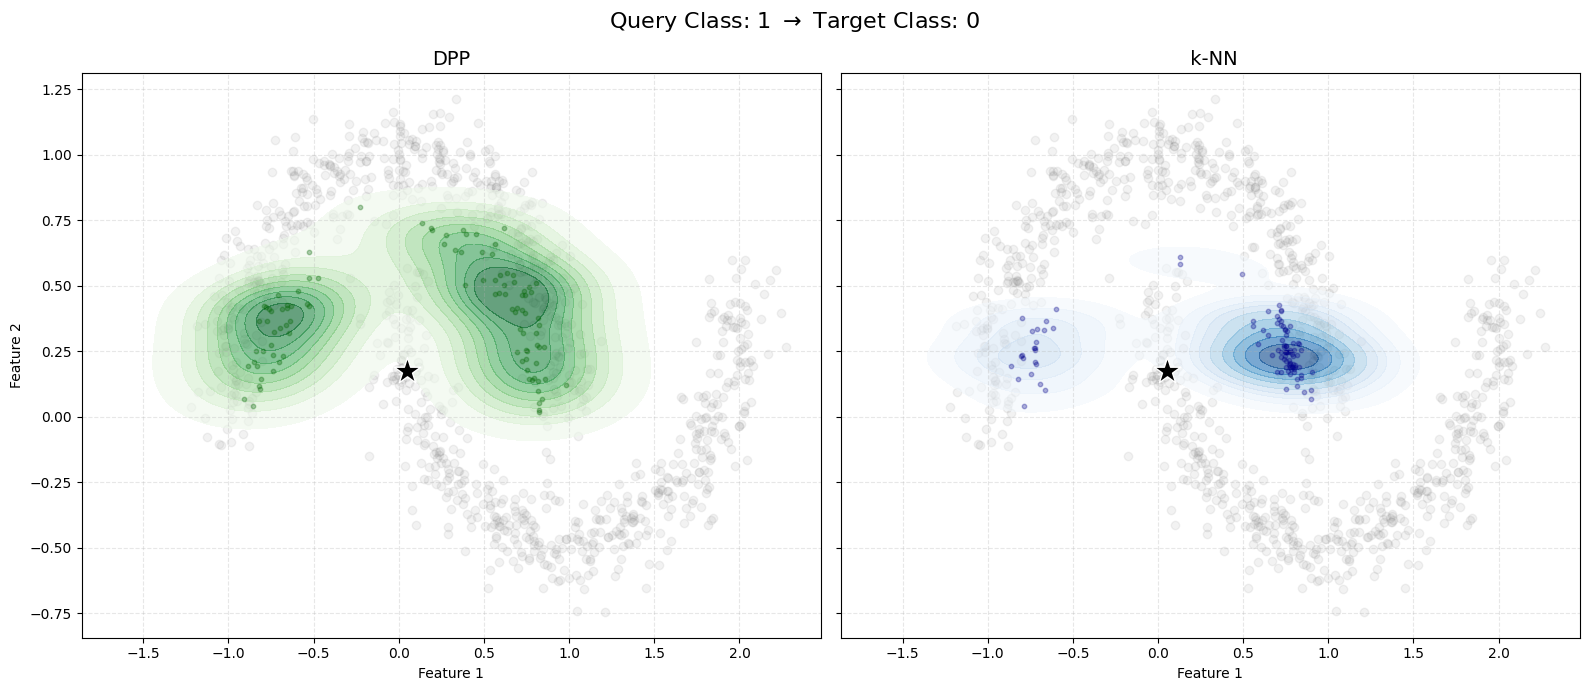

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from tabdce.model.denoise_fn import TabularEpsModel
from tabdce.model.diffusion import MixedTabularDiffusion

def compare_search_methods(
    model_dpp,
    model_knn,
    qt,
    x_bg: np.ndarray,
    y_bg: np.ndarray,
    query_idx: int,
    target_cls: int,
    device: str,
    n_cfs: int = 100
):
    x_orig_raw = x_bg[query_idx].reshape(1, -1)
    y_orig = y_bg[query_idx]
    if qt:
        x_orig_model = qt.transform(x_orig_raw).astype(np.float32)
    else:
        x_orig_model = x_orig_raw.astype(np.float32)

    x_orig_tensor = torch.from_numpy(x_orig_model).to(device)
    y_target_tensor = torch.tensor([target_cls], device=device).long()
    x_batch = x_orig_tensor.repeat(n_cfs, 1)
    y_batch = y_target_tensor.repeat(n_cfs)

    with torch.no_grad():
        # DPP
        out_dpp = model_dpp.sample_counterfactual(x_batch, y_batch).cpu().numpy()
        # KNN
        out_knn = model_knn.sample_counterfactual(x_batch, y_batch).cpu().numpy()
    if qt:
        out_dpp = qt.inverse_transform(np.clip(out_dpp, -5, 5))
        out_knn = qt.inverse_transform(np.clip(out_knn, -5, 5))

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
    
    titles = ["DPP", " k-NN"]
    samples = [out_dpp, out_knn]
    colors = ["Greens", "Blues"]
    
    for ax, sample, title, cmap in zip(axes, samples, titles, colors):
        ax.scatter(x_bg[y_bg==0, 0], x_bg[y_bg==0, 1], c='gray', alpha=0.1)
        ax.scatter(x_bg[y_bg==1, 0], x_bg[y_bg==1, 1], c='gray', alpha=0.1)
        
        # CF density
        try:
            sns.kdeplot(
                x=sample[:, 0], y=sample[:, 1], 
                fill=True, cmap=cmap, alpha=0.6, levels=10, thresh=0.05, ax=ax
            )
            # CF
            pt_color = 'darkgreen' if 'Green' in cmap else 'darkblue'
            ax.scatter(sample[:, 0], sample[:, 1], c=pt_color, s=10, alpha=0.3)
        except:
            ax.scatter(sample[:, 0], sample[:, 1], c=pt_color, alpha=0.5)

        # Punkt Query
        ax.scatter(x_orig_raw[:, 0], x_orig_raw[:, 1], c='black', marker='*', s=400, edgecolors='white', zorder=10)
        
        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Feature 1")
        ax.grid(True, linestyle='--', alpha=0.3)

    axes[0].set_ylabel("Feature 2")
    plt.suptitle(f"Query Class: {y_orig} $\\rightarrow$ Target Class: {target_cls}", fontsize=16)
    plt.tight_layout()
    plt.show()


def load_diffusion_model(path, device):
    print(f"Loading {path}...")
    ckpt = torch.load(path, map_location=device, weights_only=False)
    cfg = ckpt['config']
    qt = ckpt['dataset_qt']
    ohe = ckpt['dataset_ohe']
    
    num_num = qt.n_features_in_ if qt else 0
    cat_dims = [len(c) for c in ohe.categories_] if ohe else []
    xdim = num_num + sum(cat_dims)
    
    # Model
    denoise = TabularEpsModel(
        xdim=xdim, cat_dims=cat_dims, y_classes=2, 
        hidden=getattr(cfg.model, 'hidden_dim', 256)
    ).to(device)
    
    diff = MixedTabularDiffusion(
        denoise_fn=denoise, num_numerical=num_num, num_classes=cat_dims, 
        T=cfg.diffusion.T, device=device
    ).to(device)
    
    diff.load_state_dict(ckpt['model_state_dict'])
    diff.eval()
    return diff, qt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATH_DPP = "../checkpoints/twomoons_diffusion_model_dpp.pt" 
PATH_KNN = "../checkpoints/twomoons_diffusion_model_knn.pt"

try:
    model_dpp, qt_dpp = load_diffusion_model(PATH_DPP, DEVICE)
    model_knn, qt_knn = load_diffusion_model(PATH_KNN, DEVICE)
except FileNotFoundError as e:
    print(f"BŁĄD: {e}")
    print("MOdel not found")
qt = qt_dpp 
X_bg, y_bg = make_moons(n_samples=1000, noise=0.1, random_state=42)
queries = [0, 10, 50, 100,150, 200, 250, 300] 

for idx in queries:
    current_cls = y_bg[idx]
    target_cls = 1 - current_cls
    
    compare_search_methods(
        model_dpp=model_dpp,
        model_knn=model_knn,
        qt=qt,
        x_bg=X_bg,
        y_bg=y_bg,
        query_idx=idx,
        target_cls=target_cls,
        device=DEVICE,
        n_cfs=100
    )